In [1]:
import sys
import os
from pathlib import Path
import json
import numpy as np
from typing import Dict, Tuple, List
from joblib import Parallel, delayed
import logging
import matplotlib.pyplot as plt
import seaborn as sns
logging.getLogger('matplotlib').setLevel(logging.ERROR)
sys.path.append("..")
from src.assay_calibration.fit_utils.fit import (calculate_score_ranges,thresholds_from_prior)  # noqa: E402
from src.assay_calibration.fit_utils.two_sample import density_utils  # noqa: E402
from src.assay_calibration.fit_utils.point_ranges import (enforce_monotonicity_point_ranges, prior_equation_2c, prior_invalid, get_fit_prior, get_bootstrap_score_ranges, remove_insufficient_bootstrap_converage_points, check_thresholds_reached, extend_points_to_xlims)  # noqa: E402
from src.assay_calibration.data_utils.dataset_clinvar_version_functionality import (
    Scoreset as Scoreset_clinvar_func,
)
from src.assay_calibration.data_utils.dataset import (
    Scoreset,
)
from src.assay_calibration.fit_utils.utils import serialize_dict  # noqa: E402
from src.assay_calibration.plot_utils.utils import plot_scoreset, plot_scoreset_compare_point_assignments, plot_summary
from collections import defaultdict
import pickle


def summarize_scoreset(fits,scoreset,save_filepath,use_median_prior,use_2c_equation,n_c,benign_method, **kwargs):
    """
    Summarizes a scoreset based on the provided arguments.
    Args:
        args: An object containing the following attributes:
            - fits (List[Dict]) : List of fit results
            - scoreset_name (str) : Name of the scoreset to summarize
            - df (pandas.DataFrame, optional): A pandas DataFrame to be summarized. 
              If provided, this will be used directly.
            - pillar_df_filepath (str, optional): A file path to a CSV file. If `df` 
              is not provided, the CSV file at this path will be read into a pandas 
              DataFrame and used for summarization.
            - use_median_prior (bool). Whether to use median prior or 5-th percentile most conservative bootstrap for each threshold.
            - use_2c_equation (bool). Whether to use prior equation rather than EM for 2c.
    Optional Keyword Args:
        - point_values (List[int], optional): List of point values to assign. Defaults to 
          [1,2,3,4,5,6,7,8].
        - pathogenic_idx (int, optional): Index of the pathogenic component. Defaults to 0.
        - benign_idx (int, optional): Index of the benign component. Defaults to 1.
        - tolerance (float, optional): Tolerance for convergence in prior estimation. Defaults to 1e-4.
        - max_em_steps (int, optional): Maximum number of EM steps for prior estimation. Defaults to 10000.

    Note:
        Either `df` or `pillar_df_filepath` must be provided in `args`. If both are 
        provided, `df` takes precedence.
    """
    priors, prior, point_ranges, score_range, log_fp, log_fb, all_path_ranges, all_ben_ranges, C = process_fits(fits,scoreset,use_median_prior,use_2c_equation,benign_method,Path(save_filepath))
    results = dict(prior=prior,
                   point_ranges=point_ranges,
                   priors=priors,
                   score_range=score_range,
                   log_lr_plus=log_fp - log_fb,
                   C=C,
                   all_path_ranges=all_path_ranges,
                   all_ben_ranges=all_ben_ranges)
    results = serialize_dict(results)
    save_filepath = Path(save_filepath)
    save_filepath.parent.mkdir(exist_ok=True,parents=True)
    # with open(save_filepath,'w') as f:
    #     json.dump(results,f,indent=2)
    # save_filepath_compact = save_filepath.parent / f"{save_filepath.stem}_compact.json"
    # with open(save_filepath_compact,'w') as f:
    #     json.dump({k: results[k] for k in ['prior','point_ranges']},
    #               f,indent=2)
    scoreset_fit_figure = plot_scoreset(scoreset, results, fits,score_range, use_median_prior, use_2c_equation, n_c, benign_method, C)
    figure_filepath = save_filepath.parent / f"{save_filepath.stem}_figure_fits.png"
    scoreset_fit_figure.savefig(figure_filepath,bbox_inches='tight',dpi=300)
    plt.close(scoreset_fit_figure) 
    summary_fig = plot_summary(scoreset, fits, results, score_range, log_fp, log_fb, use_median_prior, use_2c_equation, n_c, benign_method, C, dataset)
    
    summary_figure_filepath = save_filepath.parent / f"{save_filepath.stem}_figure_summary.png"
    summary_fig.savefig(summary_figure_filepath,bbox_inches='tight',dpi=300)
    plt.close(summary_fig)

    return scoreset, results, fits, score_range, f"({'equation' if use_2c_equation else 'em'}, {'median' if use_median_prior else '5-percentile'}, {benign_method})", n_c


            


def process_fits(fits, scoreset, use_median_prior, use_2c_equation, benign_method, save_filepath, **kwargs)->Tuple[np.ndarray,Dict[int,List[Tuple[float,float]]],np.ndarray,np.ndarray,np.ndarray,List[Dict[int,List[Tuple[float,float]]]],List[Dict[int,List[Tuple[float,float]]]]]:

    log_filepath = save_filepath.parent / f"{save_filepath.stem}.log"
    with open(log_filepath,'w') as log_f:
    
        n_cores = os.cpu_count() or 1
    
        priors_filepath = save_filepath.parent / f"{save_filepath.stem.replace('_median','').replace('_5-percentile','')}_priors.npy"
        if not priors_filepath.exists():
        
            if not use_2c_equation:
                fit_priors = np.array(Parallel(n_jobs=min(len(fits), n_cores), verbose=10)(delayed(get_fit_prior)(fit, scoreset, benign_method, **kwargs)
                                           for fit in fits))
            else:
                print('computing priors with equation...')
                fit_priors = []
                for fit in fits:
                    if len(fit['fit']['weights']) == 3:
                        w_p, w_b, w_g = fit['fit']['weights']
                    elif len(fit['fit']['weights']) == 4:
                        w_p, w_b, w_g, w_s = fit['fit']['weights']
                    else:
                        raise ValueError(f"Number of samples != 3 or 4: {len(fit['fit']['weights'])}")
                    if benign_method == 'synonymous':
                        fit_priors.append(prior_equation_2c(w_p, w_s, w_g))
                    elif benign_method == 'avg':
                        w_bs = (np.array(w_b)+np.array(w_s))/2
                        fit_priors.append(prior_equation_2c(w_p, w_bs, w_g))
                    else:
                        fit_priors.append(prior_equation_2c(w_p, w_b, w_g))
                fit_priors = np.array(fit_priors)
                
            np.save(priors_filepath, fit_priors)
            
        else:
            print(f"loading priors from cached {'equation' if use_2c_equation else 'em'}")
            fit_priors = np.load(priors_filepath)

        # raise NotImplementedError
        
        nan_mask = np.isnan(fit_priors)
        invalid_range_mask = (fit_priors <= 0) | (fit_priors >= 1)
        valid_mask = ~(nan_mask | invalid_range_mask)
        
        fit_priors = fit_priors[valid_mask]
        fits = np.array(fits)[valid_mask]
        
        point_values = kwargs.get('point_values',[1,2,3,4,5,6,7,8])
        # if use_median_prior:
        prior = np.nanmedian(fit_priors)
        # else:
        #     prior = np.array([np.nanmin(fit_priors), np.nanmax(fit_priors)]) # set threshold on per-bootstrap basis, use fifth percentile for the most conservative thresholds
        observed_scores = scoreset.scores[scoreset._sample_assignments.any(1)]
        score_range = np.linspace(*np.percentile(observed_scores,[0,100]),10000) # type: ignore
    
        _log_fp = np.stack([density_utils.mixture_pdf(score_range, _fit['fit']['component_params'],_fit['fit']['weights'][0])
                            for _fit in fits])
        benign_idx = 3 if benign_method == 'synonymous' else 1
        if benign_method != 'avg':
            _log_fb = np.stack([density_utils.mixture_pdf(score_range, _fit['fit']['component_params'],_fit['fit']['weights'][benign_idx])
                               for _fit in fits])
        else:
            # print('avg b/s density:','b',fits[0]['fit']['weights'][1],'s',fits[0]['fit']['weights'][3],'bs',np.mean([fits[0]['fit']['weights'][1],fits[0]['fit']['weights'][3]]),)
            w_bs = np.array([fit['fit']['weights'][1] for fit in fits])
            w_ss = np.array([fit['fit']['weights'][3] for fit in fits])
            w_bss = (w_bs + w_ss) / 2
            
            first_weight_5th = np.nanpercentile(w_bs[:, 0], 5)
            first_weight_95th = np.nanpercentile(w_bs[:, 0], 95)
            
            idx_5th = np.nanargmin(np.abs(w_bs[:, 0] - first_weight_5th))
            idx_95th = np.nanargmin(np.abs(w_bs[:, 0] - first_weight_95th))
            
            # format with 2 significant figures
            def format_weights(w):
                return '[' + ', '.join([f'{x:.2g}' for x in w]) + ']'
            
            # Get full weight vectors at those indices
            print(f'w_benign: 5% {format_weights(w_bs[idx_5th])} 95% {format_weights(w_bs[idx_95th])}, '
                  f'w_synonymous: 5% {format_weights(w_ss[idx_5th])} 95% {format_weights(w_ss[idx_95th])}, '
                  f'w_avg: 5% {format_weights(w_bss[idx_5th])} 95% {format_weights(w_bss[idx_95th])}', 
                  file=log_f)

            _log_fb = np.stack([density_utils.mixture_pdf(score_range, _fit['fit']['component_params'],(np.array(_fit['fit']['weights'][1])+np.array(_fit['fit']['weights'][3]))/2)
                               for _fit in fits])
        log_fp = np.full((len(fits),len(score_range)),np.nan)
        log_fb = np.full((len(fits),len(score_range)),np.nan)
    
    
        boot_points_filepath = save_filepath.parent / f"{save_filepath.stem.replace('_median','').replace('_5-percentile','')}_boot_points.npz"
        
        # if True:# not boot_points_filepath.exists():
        print('getting point ranges for each bootstrap...')
        results = Parallel(
            n_jobs=min(len(fits), n_cores),
            verbose=10
        )(
            delayed(get_bootstrap_score_ranges)(fitIdx, fit, fp, fb, score_range, fit_priors, point_values)
            for fitIdx, (fit, fp, fb) in enumerate(zip(fits, _log_fp, _log_fb))
        )
            # with open(boot_points_filepath, 'wb') as f:
            #     pickle.dump(results, f)
        # else:
        #     print('loading cached point ranges for each bootstrap...')
        #     with open(boot_points_filepath, 'rb') as f:
        #         results = pickle.load(f)
        
        # Update parent arrays in main process
        ranges_pathogenic, ranges_benign = [], []
        Cs = []
        
        for fitIdx, log_fp_local, log_fb_local, ranges_p, ranges_b, C in results:
            log_fp[fitIdx] = log_fp_local
            log_fb[fitIdx] = log_fb_local
            ranges_pathogenic.append({key: np.array(value).reshape(-1) for key, value in ranges_p.items()})
            ranges_benign.append({key: np.array(value).reshape(-1) for key, value in ranges_b.items()})
            Cs.append(C)
        
        
            # np.savez_compressed(boot_points_filepath,
            #             log_fp=log_fp, log_fb=log_fb, ranges_pathogenic=ranges_pathogenic, ranges_benign=ranges_benign, Cs=Cs)
    
        # else:
        #     print('loading cached point ranges for each bootstrap...')
        #     boot_points_results = np.load(boot_points_filepath, allow_pickle=True)
        #     log_fp=boot_points_results['log_fp']
        #     log_fb=boot_points_results['log_fb']
        #     ranges_pathogenic=boot_points_results['ranges_pathogenic']
        #     ranges_benign=boot_points_results['ranges_benign']
        #     Cs=boot_points_results['Cs']
    
        log_lr_plus = log_fp - log_fb
        nan_counts = np.isnan(log_lr_plus).sum(0)
        range_subset = nan_counts < log_lr_plus.shape[1] # changed from 0. 1000/10000 is arbitrary
        point_ranges = {}
    
        print('log_lr_plus[0]', log_lr_plus[0], file=log_f)
        
        C = np.array([np.nanpercentile(Cs, 5), np.nanpercentile(Cs, 95)])
        print('ranges_p bootstrap 0, score +8:',ranges_pathogenic[0][1], file=log_f)
    
        percent_no_evidence = defaultdict(int)
        # # print('\n\n', file=log_f)
        # for i in range(len(ranges_pathogenic)):
        #     # print(f'Bootstrap {i}: ',end='', file=log_f)
        #     for point in point_values:
        #         # print(f'{point} {ranges_pathogenic[i][point]},', end=' ', file=log_f)
        #         if len(ranges_pathogenic[i][point]) == 0:
        #             percent_no_evidence[point] += 1
        #         if len(ranges_benign[i][-point]) == 0:
        #             percent_no_evidence[-point] += 1
        # #     print('', file=log_f)
        # # print('\n\n', file=log_f)

        # redo = False
        # for point_p in point_values:
        #     if point_p == 1:
        #         continue
        #     point_b = -1*point_p
        #     prev_point_p = point_p-1
        #     prev_point_b = point_b+1

        #     if percent_no_evidence[point_p] < percent_no_evidence[prev_point_p] or percent_no_evidence[point_b] < percent_no_evidence[prev_point_b]
        #     percent_no_evidence[point]
            

            
        # if ranges don't capture point values
        # if redo:
        # percent_no_evidence = defaultdict(int)
        # assert log_lr_plus.shape[0] == len(fit_priors)
        # for bootstrap_idx in range(log_lr_plus.shape[0]):

        #     if prior_invalid(fit_priors[bootstrap_idx]):
        #         continue
            
        #     tauP,tauB,_ = list(thresholds_from_prior(fit_priors[bootstrap_idx],point_values))
        #     tauP, tauB = np.log(tauP), np.log(tauB)
            
        #     reached_p = check_thresholds_reached(log_lr_plus[bootstrap_idx], tauP, point_values, "pathogenic")
        #     for p in point_values:
        #         if not reached_p[p]:
        #             percent_no_evidence[p] += 1
            
        #     reached_b = check_thresholds_reached(log_lr_plus[bootstrap_idx], tauB, point_values, "benign")
        #     for p in point_values:
        #         if not reached_b[-p]:
        #             percent_no_evidence[-p] += 1

        def get_no_evidence_bootstraps(idx):
            if prior_invalid(fit_priors[idx]):
                return {}
            
            tauP, tauB, _ = thresholds_from_prior(fit_priors[idx], point_values)
            tauP, tauB = np.log(tauP), np.log(tauB)
            
            failures = {}
            reached_p = check_thresholds_reached(log_lr_plus[idx], tauP, point_values, "pathogenic")
            reached_b = check_thresholds_reached(log_lr_plus[idx], tauB, point_values, "benign")
            
            for p in point_values:
                if not reached_p[p]:
                    failures[p] = 1
                if not reached_b[-p]:
                    failures[-p] = 1
            
            return failures
        
        results = Parallel(n_jobs=min(len(fits), n_cores), verbose=10)(
            delayed(get_no_evidence_bootstraps)(i) for i in range(log_lr_plus.shape[0])
        )
    
        percent_no_evidence = {point: 0.0 for point in point_values + list(-1*np.array(point_values))} 
        
        if not use_median_prior:
            for result in results:
                for point, count in result.items():
                    percent_no_evidence[point] += count
                    
            for point in point_values:
                percent_no_evidence[point] /= len(ranges_pathogenic)
                print(f'{point}: {100 * percent_no_evidence[point]:.1f}% of bootstrap did not reach evidence', file=log_f)
            for point in point_values:
                percent_no_evidence[-point] /= len(ranges_benign)
                print(f'{-point}: {100 * percent_no_evidence[-point]:.1f}% of bootstrap did not reach evidence', file=log_f)
        else:
            print(f'not filtering out points with insufficient bootstraps reaching evidence', file=log_f)
    
        
        # print('nan_counts',nan_counts, nan_counts.shape)
        print('range_subset true',sum(range_subset), range_subset.shape, file=log_f)
        # print('log_lr_plus.shape',log_lr_plus.shape, log_lr_plus[:,0])
        
        # if points 1 and -1 are out of order, consider scoreset flipped
        # scoreset_flipped = len(ranges_pathogenic[0][1]) != 0 and len(ranges_benign[0][-1]) != 0 and ranges_pathogenic[0][1][-1] >= ranges_benign[0][-1][0]
    
        scoreset_flipped = False
        if benign_method != 'avg':
            _isflipped = [_fit["fit"]["weights"][0][0] < _fit["fit"]["weights"][1][0] or _fit["fit"]["weights"][0][-1] > _fit["fit"]["weights"][1][-1] for _fit in fits] # P 1st weight < B 1st weight or P last weight > B last weight. `or` is for 3c weird cases
        else:
            _isflipped = [_fit["fit"]["weights"][0][0] < (np.array(_fit['fit']['weights'][1][0])+np.array(_fit['fit']['weights'][3][0]))/2 or _fit["fit"]["weights"][0][-1] > (np.array(_fit['fit']['weights'][1][-1])+np.array(_fit['fit']['weights'][3][-1]))/2 for _fit in fits]
        if np.sum(_isflipped) > len(fits) / 2:
            scoreset_flipped = True



        print(f"scoreset_flipped: {scoreset_flipped}", file=log_f)
        
        p_xaxis_5percentile_conservative = 5 if not scoreset_flipped else 95
        b_xaxis_5percentile_conservative = 95 if not scoreset_flipped else 5
    
    
        if prior > 0 and prior < 1:
            
            if use_median_prior:
                print('using median prior to get unified thresholds...')
                # point_ranges = {point_value : [score1, score2, ...]}
                point_ranges_pathogenic, point_ranges_benign, C = calculate_score_ranges(np.nanpercentile(log_lr_plus[:,range_subset],
                                                                                                    5,axis=0),
                                                                                        np.nanpercentile(log_lr_plus[:,range_subset],
                                                                                                        95,axis=0),
                                                                                        prior,
                                                                                        score_range[range_subset],
                                                                                        point_values,)
                point_ranges = {**point_ranges_pathogenic,**point_ranges_benign}
                
            else:
                # use 5-percentile of most conservative bootstrap thresholds for each point assignment
                print('using 5-percentile to get conservative thresholds...')
                
                # print('ranges_benign[0]',ranges_benign[0])
                # print('scoreset_flipped:',scoreset_flipped,len(ranges_pathogenic[0][1]) != 0 , len(ranges_benign[0][-1]) != 0 , ranges_pathogenic[0][1][-1] >= ranges_benign[0][-1][0])
    
                p_max = max if not scoreset_flipped else min
                b_min = min if not scoreset_flipped else max
                p_inf = -np.inf if not scoreset_flipped else np.inf
                b_inf = np.inf if not scoreset_flipped else -np.inf
    
                conservative_thresholds = {}
                # print('ranges_pathogenic',ranges_pathogenic[0])
                # print('ranges_benign',ranges_benign[0])
                print('boot prior:',np.nanmin(fit_priors), '-', np.nanmax(fit_priors), file=log_f)
                for point_value in point_values: # 1,2,...,8
    
                    conservative_thresholds[point_value] = np.nanpercentile([p_max(ranges_p[point_value]) if len(ranges_p[point_value]) > 0 else p_inf for ranges_p in ranges_pathogenic], p_xaxis_5percentile_conservative)
                    print(point_value,'nan bootstrap points:',np.isnan([p_max(ranges_p[point_value]) if len(ranges_p[point_value]) > 0 else p_inf for ranges_p in ranges_pathogenic]).sum(), file=log_f)
                    conservative_thresholds[-1*point_value] = np.nanpercentile([b_min(ranges_b[-1*point_value]) if len(ranges_b[-1*point_value]) > 0 else b_inf for ranges_b in ranges_benign], b_xaxis_5percentile_conservative)
    
                print('conservative_thresholds',conservative_thresholds, file=log_f)
                for point_value, threshold in conservative_thresholds.items():
                    assert point_value != 0
                    if np.isnan(threshold) or np.isinf(threshold):
                        point_ranges[point_value] = []
                        continue
                    valid_scores = score_range[range_subset]
                    if (point_value > 0 and not scoreset_flipped) or (point_value < 0 and scoreset_flipped): # pathogenic or flipped benign
                        if abs(point_value) == max(point_values):
                            point_ranges[point_value] = [valid_scores[0], threshold]
                        else:
                            lower_lim = conservative_thresholds[point_value+1] if point_value > 0 else conservative_thresholds[point_value-1]
                            if np.isnan(lower_lim):
                                point_ranges[point_value] = [valid_scores[0], threshold]
                            else:
                                # point_ranges[point_value] = valid_scores[(valid_scores > lower_lim) & (valid_scores < threshold)]
                                point_ranges[point_value] = [lower_lim, threshold]
                    else: # benign
                        if abs(point_value) == max(point_values):
                            point_ranges[point_value] = [threshold, valid_scores[-1]]
                        else:
                            upper_lim = conservative_thresholds[point_value-1] if point_value < 0 else conservative_thresholds[point_value+1]
                            if np.isnan(upper_lim):
                                point_ranges[point_value] = [threshold, valid_scores[-1]]
                            else:
                                # point_ranges[point_value] = valid_scores[(valid_scores < upper_lim) & (valid_scores > threshold)]   
                                point_ranges[point_value] = [threshold, upper_lim]
                    
                for point_value in point_ranges:
                    if len(point_ranges[point_value]) != 0:
                        point_ranges[point_value] = [point_ranges[point_value]]
                # print('point_ranges',point_ranges)
    
        print(f"point_ranges: {point_ranges}", file=log_f)

        print(f"lr path: {np.nanpercentile(log_lr_plus[:,range_subset],5,axis=0)}", file=log_f)
        print(f"lr ben: {np.nanpercentile(log_lr_plus[:,range_subset],95,axis=0)}", file=log_f)
        
        # plot_summary(scoreset, fits, dict(point_ranges=point_ranges, prior=prior, priors=fit_priors), score_range[range_subset], log_fp[:,range_subset], log_fb[:,range_subset], use_median_prior, use_2c_equation, "3c", benign_method, C, "")
        
        remove_insufficient_bootstrap_converage_points(point_ranges, percent_no_evidence, point_values)
        print(f"point_ranges after removing insufficient bootstraps: {point_ranges}", file=log_f)
        # enforce_monotonicity_point_ranges(point_ranges, point_values, score_range[range_subset], scoreset_flipped=scoreset_flipped, log_f=log_f)
        # need this twice to recognize going back to no evidence after flattening, but ideally requires better implementation
        # enforce_monotonicity_point_ranges(point_ranges, point_values, score_range[range_subset], scoreset_flipped=scoreset_flipped, log_f=log_f)
        enforce_monotonicity_point_ranges(point_ranges, point_values, score_range[range_subset], scoreset_flipped=scoreset_flipped, liberal=True, log_f=log_f)
        extend_points_to_xlims(point_ranges, point_values, score_range[range_subset], scoreset_flipped)
        print(f"point_ranges after enforcing monotonicity: {point_ranges}", file=log_f)
        
    
    return fit_priors, prior, point_ranges,score_range[range_subset],log_fp[:,range_subset], log_fb[:,range_subset], ranges_pathogenic, ranges_benign, C
    



    


In [2]:
import gzip

mode = "point_assignment_11_22_25_rerun"

if mode == "point_assignment_comparison":
    results_name = 'initial_datasets_results_1000bootstraps_100fits'
    with gzip.open(f'/data/ross/assay_calibration/{results_name}.json.gz', 'rt', encoding='utf-8') as f:
        results = json.load(f)
    
    results_name = 'clinvar_circ_datasets_results_1000bootstraps_100fits'
    with gzip.open(f'/data/ross/assay_calibration/{results_name}.json.gz', 'rt', encoding='utf-8') as f:
        results = {**results, **json.load(f)}

elif mode == "point_assignment_clinvar_2018":
    results_name = 'clinvar_2018_datasets_results_1000bootstraps_100fits'
    with gzip.open(f'/data/ross/assay_calibration/{results_name}.json.gz', 'rt', encoding='utf-8') as f:
        results = json.load(f)
        
elif mode == "point_assignment_semifinal_rerun":
    results_name = 'semifinal_run_datasets_results_1000bootstraps_100fits'
    with gzip.open(f'/data/ross/assay_calibration/{results_name}.json.gz', 'rt', encoding='utf-8') as f:
        results = json.load(f)
elif mode == "point_assignment_11_22_25_rerun":
    results_name = 'extra_clinvar_datasets_results_1000bootstraps_100fits'
    with gzip.open(f'/data/ross/assay_calibration/{results_name}.json.gz', 'rt', encoding='utf-8') as f:
        results = json.load(f)
    results_name = "11_22_25_rerun_datasets_results_1000bootstraps_100fits"
    with gzip.open(f'/data/ross/assay_calibration/{results_name}.json.gz', 'rt', encoding='utf-8') as f:
        results = {**results, **json.load(f)}
    

# else:
#     results_name = 'unconstrained_rerun_initial_datasets_results_1000bootstraps_100fits'
#     with gzip.open(f'/data/ross/assay_calibration/{results_name}.json.gz', 'rt', encoding='utf-8') as f:
#         results = json.load(f)

if 'KCNH2_Kozek_Glazer_2020' in results:
    del results['KCNH2_Kozek_Glazer_2020'] # ignore this dataset
    
if 'TP53_Fayer_2021_meta_clinvar_2018' in results:
    del results['TP53_Fayer_2021_meta_clinvar_2018'] # ignore this dataset


In [17]:
print(*results.keys(),sep='\n')

MSH2_Jia_2021_clinvar_2018
TP53_Boettcher_2019_clinvar_2018
TP53_Fortuno_2021_Kato_meta_clinvar_2018
TP53_Giacomelli_2018_combined_score_clinvar_2018
TP53_Giacomelli_2018_p53WT_Nutlin3_clinvar_2018
TP53_Giacomelli_2018_p53null_Nutlin3_clinvar_2018
TP53_Giacomelli_2018_p53null_etoposide_clinvar_2018
TP53_Kato_2003_AIP1nWT_clinvar_2018
TP53_Kato_2003_BAXnWT_clinvar_2018
TP53_Kato_2003_GADD45nWT_clinvar_2018
TP53_Kato_2003_MDM2nWT_clinvar_2018
TP53_Kato_2003_NOXAnWT_clinvar_2018
TP53_Kato_2003_P53R2nWT_clinvar_2018
TP53_Kato_2003_WAF1nWT_clinvar_2018
TP53_Kato_2003_h1433snWT_clinvar_2018
CALM1_CALM2_CALM3_Weile_2017_NEW_not_clinvar_2018
G6PD_unpublished_NEW_not_clinvar_2018
TPK1_Weile_2017_NEW_not_clinvar_2018
XRCC2_unpublished_NEW_not_clinvar_2018


In [18]:
prev_dataset_configs = {
    "CALM1_CALM2_CALM3_Weile_2017": ("3c", "avg"),
    "G6PD_unpublished": ("3c", "avg"),
    "MSH2_Jia_2021": ("2c", "avg"),
    "TP53_Boettcher_2019": ("2c", "avg"),
    "TP53_Fortuno_2021_Kato_meta": ("2c", "avg"),
    "TP53_Giacomelli_2018_combined_score": ("2c", "avg"),
    "TP53_Giacomelli_2018_p53WT_Nutlin3": ("2c", "avg"),
    "TP53_Giacomelli_2018_p53null_Nutlin3": ("2c", "avg"),
    "TP53_Giacomelli_2018_p53null_etoposide": ("2c", "avg"),
    "TP53_Kato_2003_AIP1nWT": ("3c", "avg"),
    "TP53_Kato_2003_BAXnWT": ("2c", "avg"),
    "TP53_Kato_2003_GADD45nWT": ("2c", "avg"),
    "TP53_Kato_2003_MDM2nWT": ("3c", "avg"),
    "TP53_Kato_2003_NOXAnWT": ("3c", "avg"),
    "TP53_Kato_2003_P53R2nWT": ("2c", "avg"),
    "TP53_Kato_2003_WAF1nWT": ("3c", "avg"),
    "TP53_Kato_2003_h1433snWT": ("3c", "avg"),
    "TPK1_Weile_2017": ("2c", "avg"),
    "XRCC2_unpublished": ("2c", "avg"),
}

In [23]:
### import pickle

start = False
for dataset in results.keys(): # PRIORITIZE URGENT DATASETS TO RUN FIRST, REST ALPHANUMERIC

    print(dataset,"start")
    # if dataset != "VHL_Buckley_2024":
    #     continue

    # if dataset not in ["TP53_Kato_2003_h1433snWT", "TP53_Kato_2003_NOXAnWT", "TP53_Kato_2003_AIP1nWT", "TP53_Fortuno_2021_Kato_meta"]:
    #     continue
    
    # if dataset == 'TP53_Fayer_2021_meta_clinvar_2018':
    #     start = True
    # if not start:
    #     continue

    if mode == "point_assignment_comparison":
        scoresets_dir = "/data/ross/assay_calibration/scoresets"
    elif mode == "point_assignment_clinvar_2018":
        scoresets_dir = "/data/ross/assay_calibration/scoresets_old_clinvar"
    elif mode == "point_assignment_semifinal_rerun":
        scoresets_dir = "/data/ross/assay_calibration/scoresets_semifinal_run"
    elif mode == "point_assignment_11_22_25_rerun":
        scoresets_dir = "/data/ross/assay_calibration/scoresets_11_22_25_rerun"
    else:
        raise ValueError("no specified scoreset dir")
    
    dataset_f = f"{scoresets_dir}/{dataset}.json"

    # Load dataset once
    clinvar_release = '2018' if 'clinvar_2018' in dataset else '2025'    
    if "not_clinvar_2018" in dataset:
        clinvar_release = '2025'

    if 'clinvar_2018' in dataset:
        scoreset = Scoreset_clinvar_func.from_json(dataset_f, 
                            clinvar_release=clinvar_release,
                            min_clinvar_star=1)
    else:
        scoreset = Scoreset.from_json(dataset_f)

    print(scoreset)
    
    n_samples = len([s for s in scoreset.samples])

    if n_samples < 3:
        continue

    dataset_save = dataset.replace("_NEW_not_clinvar_2018","")

    if dataset_save.replace("_clinvar_2018","") in prev_dataset_configs:
        n_c_options, benign_options = prev_dataset_configs[dataset_save.replace("_clinvar_2018","")]
    else:
        n_c_options, benign_options = ["2c", "3c"], ["benign", "avg"]

    save_dir = f'/data/ross/assay_calibration/{mode}/{dataset_save}'
    os.makedirs(save_dir, exist_ok=True)

    scoresets_dict, summary_dict, scoreset_fits_dict, score_ranges_dict = {},{},{},{}
    figure_filepath = f"{save_dir}/{dataset_save}_point_comparison.png"
    # if os.path.exists(figure_filepath):
    #     print(f'path exists: {figure_filepath}, skipping')
    #     continue
    
    for n_c in [n_c_options]:#['2c','3c']:#,'4c']:

        if len(results[dataset]) == 0:
            print('dataset empty')
            continue

        if n_c == '4c' and n_c not in results[dataset][list(results[dataset].keys())[0]]:
            # print(results[dataset][list(results[dataset].keys())[0]])
            continue

        boot_results = [results[dataset][key][n_c] for key,val in results[dataset].items()]
        
        # n_count, nn_count = 0,0
        # for b in boot_results:
        #     if b is None:
        #         n_count += 1
        #     else:
        #         nn_count += 1
        
        # print(n_count, nn_count)

        # boot_results = boot_results[:20] # for speed of dev

        for benign_method in [benign_options]:#['benign', 'avg']:
            use_median_prior, use_2c_equation = True, False
            # for use_median_prior in [True]:
            if True:
            # for use_median_prior, use_2c_equation in zip([False, True, False], [False, False, True]):
                    
                # only do synonymous analysis if synonymous exists and only for one config
                if benign_method != 'benign' and n_samples != 4:
                    benign_method = "benign"
                    
                if n_c != '2c' and use_2c_equation: # N/A
                    continue
    
                experiment_code = f'{dataset_save}_{n_c}_{"median" if use_median_prior else "5-percentile"}_{"equation" if use_2c_equation else "em"}{"_"+benign_method if benign_method != "benign" else ""}'
                
                save_filepath = f'{save_dir}/{experiment_code}.json'
                pkl_filepath = f'{save_dir}/{experiment_code}.pkl'
        
                # if os.path.exists(pkl_filepath):
                #     print(f'{pkl_filepath} exists')
                #     with open(pkl_filepath,'rb') as f:
                #         scoreset, indv_summary, fits, score_range, config, n_c = pickle.load(f)
                        
                #     if not config.startswith('(e'): # old config, swap
                #         config = f"({'equation' if use_2c_equation else 'em'}, {'median' if use_median_prior else '5-percentile'}, {benign_method})"
                    
                #     if 'C' in indv_summary:
                #         scoresets_dict[(config,n_c)] = scoreset
                #         summary_dict[(config,n_c)] = indv_summary
                #         scoreset_fits_dict[(config,n_c)] = fits
                #         score_ranges_dict[(config,n_c)] = score_range
                #         continue ### rerun everthing
                    
                print(f'\n{"-"*80}\nStarting {experiment_code}...\n{"-"*80}\n')
                try:
                
                    scoreset, indv_summary, fits, score_range, config, _ = summarize_scoreset(boot_results,scoreset,save_filepath,use_median_prior,use_2c_equation,n_c,benign_method)
                    del indv_summary['all_path_ranges']
                    del indv_summary['all_ben_ranges']
                    
                    scoresets_dict[(config,n_c)] = scoreset
                    summary_dict[(config,n_c)] = indv_summary
                    scoreset_fits_dict[(config,n_c)] = fits
                    score_ranges_dict[(config,n_c)] = score_range
            
                    with open(pkl_filepath, 'wb') as f:
                        pickle.dump((scoreset, indv_summary, fits, score_range, config, n_c), f)

                except NotImplementedError as e:
                    print(e)

    try:
        
        point_comparison_figure = plot_scoreset_compare_point_assignments(dataset_save, scoresets_dict, summary_dict, scoreset_fits_dict, score_ranges_dict, n_samples)
        point_comparison_figure.savefig(figure_filepath,bbox_inches='tight',dpi=300)
        plt.close(point_comparison_figure)

    except Exception as e:
        print(e)

MSH2_Jia_2021_clinvar_2018 start
MSH2_Jia_2021: 16749 total variants
	Pathogenic/Likely Pathogenic: 30 variants
	Benign/Likely Benign: 8 variants
	population: 590 variants


--------------------------------------------------------------------------------
Starting MSH2_Jia_2021_clinvar_2018_2c_median_em...
--------------------------------------------------------------------------------

loading priors from cached em
getting point ranges for each bootstrap...


[Parallel(n_jobs=72)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=72)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=72)]: Done  77 tasks      | elapsed:    2.8s
[Parallel(n_jobs=72)]: Done  98 tasks      | elapsed:    2.9s
[Parallel(n_jobs=72)]: Done 121 tasks      | elapsed:    3.0s
[Parallel(n_jobs=72)]: Done 144 tasks      | elapsed:    3.9s
[Parallel(n_jobs=72)]: Done 169 tasks      | elapsed:    4.3s
[Parallel(n_jobs=72)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=72)]: Done 221 tasks      | elapsed:    5.5s
[Parallel(n_jobs=72)]: Done 248 tasks      | elapsed:    5.7s
[Parallel(n_jobs=72)]: Done 277 tasks      | elapsed:    6.5s
[Parallel(n_jobs=72)]: Done 306 tasks      | elapsed:    7.0s
[Parallel(n_jobs=72)]: Done 337 tasks      | elapsed:  

using median prior to get unified thresholds...
extending points to xlims...
[(-8, []), (-7, []), (-6, []), (-5, []), (-4, []), (-3, []), (-2, []), (-1, [[-6.57612570132457, -1.459255635939937]]), (1, [[0.06647152340651008, 0.2974247326252266]]), (2, [[0.2974247326252266, 0.5307712393488009]]), (3, [[0.5307712393488009, 0.7832641261112325]]), (4, [[0.7832641261112325, 1.0561000416649504]]), (5, [[1.0561000416649504, 1.3540655810196682]]), (6, [[1.3540655810196682, 1.6951104754618145]]), (7, [[1.6951104754618145, 2.088807915010819]]), (8, [[2.088807915010819, 5.38916517420886]])]
TP53_Boettcher_2019_clinvar_2018 start
TP53_Boettcher_2019: 7873 total variants
	Pathogenic/Likely Pathogenic: 37 variants
	Benign/Likely Benign: 3 variants
	population: 144 variants
	Synonymous: 34 variants


--------------------------------------------------------------------------------
Starting TP53_Boettcher_2019_clinvar_2018_2c_median_em_avg...
-------------------------------------------------------------

[Parallel(n_jobs=72)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=72)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=72)]: Done  77 tasks      | elapsed:    2.8s
[Parallel(n_jobs=72)]: Done  98 tasks      | elapsed:    2.8s
[Parallel(n_jobs=72)]: Done 121 tasks      | elapsed:    3.0s
[Parallel(n_jobs=72)]: Done 144 tasks      | elapsed:    4.0s
[Parallel(n_jobs=72)]: Done 169 tasks      | elapsed:    4.2s
[Parallel(n_jobs=72)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=72)]: Done 221 tasks      | elapsed:    5.5s
[Parallel(n_jobs=72)]: Done 248 tasks      | elapsed:    5.8s
[Parallel(n_jobs=72)]: Done 277 tasks      | elapsed:    6.3s
[Parallel(n_jobs=72)]: Done 306 tasks      | elapsed:    7.0s
[Parallel(n_jobs=72)]: Done 337 tasks      | elapsed:  

using median prior to get unified thresholds...
extending points to xlims...
[(-8, []), (-7, []), (-6, []), (-5, []), (-4, []), (-3, []), (-2, []), (-1, [[-0.7638389526838718, 0.25615737412738304]]), (1, [[0.39595545448184466, 0.4293400706858952]]), (2, [[0.4293400706858952, 0.4620826750398679]]), (3, [[0.4620826750398679, 0.4967513149440741]]), (4, [[0.4967513149440741, 0.53463001409867]]), (5, [[0.53463001409867, 0.5778053110164083]]), (6, [[0.5778053110164083, 0.6280427382850036]]), (7, [[0.6280427382850036, 0.6912809055176761]]), (8, [[0.6912809055176761, 0.8410301695483451]])]
TP53_Fortuno_2021_Kato_meta_clinvar_2018 start
TP53_Fortuno_2021_Kato_meta: 2314 total variants
	Pathogenic/Likely Pathogenic: 32 variants
	Benign/Likely Benign: 4 variants
	population: 142 variants


--------------------------------------------------------------------------------
Starting TP53_Fortuno_2021_Kato_meta_clinvar_2018_2c_median_em...
---------------------------------------------------------------

[Parallel(n_jobs=72)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=72)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  77 tasks      | elapsed:    2.8s
[Parallel(n_jobs=72)]: Done  98 tasks      | elapsed:    2.9s
[Parallel(n_jobs=72)]: Done 121 tasks      | elapsed:    2.9s
[Parallel(n_jobs=72)]: Done 144 tasks      | elapsed:    4.1s
[Parallel(n_jobs=72)]: Done 169 tasks      | elapsed:    4.3s
[Parallel(n_jobs=72)]: Done 194 tasks      | elapsed:    4.4s
[Parallel(n_jobs=72)]: Done 221 tasks      | elapsed:    5.5s
[Parallel(n_jobs=72)]: Done 248 tasks      | elapsed:    5.8s
[Parallel(n_jobs=72)]: Done 277 tasks      | elapsed:    6.3s
[Parallel(n_jobs=72)]: Done 306 tasks      | elapsed:    7.1s
[Parallel(n_jobs=72)]: Done 337 tasks      | elapsed:  

using median prior to get unified thresholds...
extending points to xlims...
[(-8, [[73.3994699469947, 147.7]]), (-7, [[70.22360236023601, 73.3994699469947]]), (-6, [[67.06250625062506, 70.22360236023601]]), (-5, [[63.87186718671867, 67.06250625062506]]), (-4, [[60.843714371437144, 63.87186718671867]]), (-3, [[57.66784678467847, 60.843714371437144]]), (-2, [[54.52152215221522, 57.66784678467847]]), (-1, [[51.33088308830883, 54.52152215221522]]), (1, [[31.315531553155314, 33.974397439743974]]), (2, [[28.50895089508951, 31.315531553155314]]), (3, [[25.495569556955694, 28.50895089508951]]), (4, [[22.216301630163017, 25.495569556955694]]), (5, [[18.75977597759776, 22.216301630163017]]), (6, [[14.948734873487348, 18.75977597759776]]), (7, [[10.842264226422643, 14.948734873487348]]), (8, [[0.0, 10.842264226422643]])]
TP53_Giacomelli_2018_combined_score_clinvar_2018 start
TP53_Giacomelli_2018_combined_score: 8237 total variants
	Pathogenic/Likely Pathogenic: 40 variants
	Benign/Likely Benign:

[Parallel(n_jobs=72)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=72)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  77 tasks      | elapsed:    2.8s
[Parallel(n_jobs=72)]: Done  98 tasks      | elapsed:    2.8s
[Parallel(n_jobs=72)]: Done 121 tasks      | elapsed:    3.0s
[Parallel(n_jobs=72)]: Done 144 tasks      | elapsed:    4.1s
[Parallel(n_jobs=72)]: Done 169 tasks      | elapsed:    4.2s
[Parallel(n_jobs=72)]: Done 194 tasks      | elapsed:    4.4s
[Parallel(n_jobs=72)]: Done 221 tasks      | elapsed:    5.5s
[Parallel(n_jobs=72)]: Done 248 tasks      | elapsed:    5.7s
[Parallel(n_jobs=72)]: Done 277 tasks      | elapsed:    6.4s
[Parallel(n_jobs=72)]: Done 306 tasks      | elapsed:    7.1s
[Parallel(n_jobs=72)]: Done 337 tasks      | elapsed:  

using median prior to get unified thresholds...
extending points to xlims...
[(-8, []), (-7, []), (-6, []), (-5, []), (-4, []), (-3, []), (-2, []), (-1, [[-1.1466757483584735, 0.09555122087608892]]), (1, [[0.6333167562708304, 0.7677581401195159]]), (2, [[0.7677581401195159, 0.8862149857611388]]), (3, [[0.8862149857611388, 0.993825180476541]]), (4, [[0.993825180476541, 1.0965829260933706]]), (5, [[1.0965829260933706, 1.190777526242131]]), (6, [[1.190777526242131, 1.2835449354795467]]), (7, [[1.2835449354795467, 1.3748851538056175]]), (8, [[1.3748851538056175, 1.7074206361489688]])]
TP53_Giacomelli_2018_p53WT_Nutlin3_clinvar_2018 start
TP53_Giacomelli_2018_p53WT_Nutlin3: 8237 total variants
	Pathogenic/Likely Pathogenic: 40 variants
	Benign/Likely Benign: 5 variants
	population: 147 variants
	Synonymous: 356 variants


--------------------------------------------------------------------------------
Starting TP53_Giacomelli_2018_p53WT_Nutlin3_clinvar_2018_2c_median_em_avg...
-------------

[Parallel(n_jobs=72)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=72)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=72)]: Done  77 tasks      | elapsed:    2.8s
[Parallel(n_jobs=72)]: Done  98 tasks      | elapsed:    2.8s
[Parallel(n_jobs=72)]: Done 121 tasks      | elapsed:    2.9s
[Parallel(n_jobs=72)]: Done 144 tasks      | elapsed:    3.9s
[Parallel(n_jobs=72)]: Done 169 tasks      | elapsed:    4.3s
[Parallel(n_jobs=72)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=72)]: Done 221 tasks      | elapsed:    5.6s
[Parallel(n_jobs=72)]: Done 248 tasks      | elapsed:    5.7s
[Parallel(n_jobs=72)]: Done 277 tasks      | elapsed:    6.3s
[Parallel(n_jobs=72)]: Done 306 tasks      | elapsed:    7.1s
[Parallel(n_jobs=72)]: Done 337 tasks      | elapsed:  

using median prior to get unified thresholds...
extending points to xlims...
[(-8, []), (-7, []), (-6, []), (-5, []), (-4, []), (-3, []), (-2, []), (-1, [[-1.1786008821582206, 0.4906115046555892]]), (1, [[1.080836048054226, 1.1819474250798372]]), (2, [[1.1819474250798372, 1.2816593366794886]]), (3, [[1.2816593366794886, 1.3901179071913896]]), (4, [[1.3901179071913896, 1.503124740337661]]), (5, [[1.503124740337661, 1.6465699464985626]]), (6, [[1.6465699464985626, 1.8169548621091947]]), (7, [[1.8169548621091947, 2.0597621135132576]]), (8, [[2.0597621135132576, 2.319712816385331]])]
TP53_Giacomelli_2018_p53null_Nutlin3_clinvar_2018 start
TP53_Giacomelli_2018_p53null_Nutlin3: 8237 total variants
	Pathogenic/Likely Pathogenic: 40 variants
	Benign/Likely Benign: 5 variants
	population: 147 variants
	Synonymous: 356 variants


--------------------------------------------------------------------------------
Starting TP53_Giacomelli_2018_p53null_Nutlin3_clinvar_2018_2c_median_em_avg...
--------

[Parallel(n_jobs=72)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=72)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=72)]: Done  77 tasks      | elapsed:    2.8s
[Parallel(n_jobs=72)]: Done  98 tasks      | elapsed:    2.8s
[Parallel(n_jobs=72)]: Done 121 tasks      | elapsed:    3.0s
[Parallel(n_jobs=72)]: Done 144 tasks      | elapsed:    3.9s
[Parallel(n_jobs=72)]: Done 169 tasks      | elapsed:    4.2s
[Parallel(n_jobs=72)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=72)]: Done 221 tasks      | elapsed:    5.5s
[Parallel(n_jobs=72)]: Done 248 tasks      | elapsed:    5.7s
[Parallel(n_jobs=72)]: Done 277 tasks      | elapsed:    6.4s
[Parallel(n_jobs=72)]: Done 306 tasks      | elapsed:    7.0s
[Parallel(n_jobs=72)]: Done 337 tasks      | elapsed:  

using median prior to get unified thresholds...
extending points to xlims...
[(-8, []), (-7, []), (-6, []), (-5, []), (-4, []), (-3, []), (-2, []), (-1, [[-1.8068381310588144, -0.2991147275298749]]), (1, [[0.79301825066737, 1.6445644128711]]), (2, []), (3, []), (4, []), (5, []), (6, []), (7, []), (8, [])]
TP53_Giacomelli_2018_p53null_etoposide_clinvar_2018 start
TP53_Giacomelli_2018_p53null_etoposide: 8237 total variants
	Pathogenic/Likely Pathogenic: 40 variants
	Benign/Likely Benign: 5 variants
	population: 147 variants
	Synonymous: 356 variants


--------------------------------------------------------------------------------
Starting TP53_Giacomelli_2018_p53null_etoposide_clinvar_2018_2c_median_em_avg...
--------------------------------------------------------------------------------

loading priors from cached em
getting point ranges for each bootstrap...


[Parallel(n_jobs=72)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=72)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=72)]: Done  77 tasks      | elapsed:    2.7s
[Parallel(n_jobs=72)]: Done  98 tasks      | elapsed:    2.9s
[Parallel(n_jobs=72)]: Done 121 tasks      | elapsed:    3.0s
[Parallel(n_jobs=72)]: Done 144 tasks      | elapsed:    3.9s
[Parallel(n_jobs=72)]: Done 169 tasks      | elapsed:    4.3s
[Parallel(n_jobs=72)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=72)]: Done 221 tasks      | elapsed:    5.5s
[Parallel(n_jobs=72)]: Done 248 tasks      | elapsed:    5.8s
[Parallel(n_jobs=72)]: Done 277 tasks      | elapsed:    6.2s
[Parallel(n_jobs=72)]: Done 306 tasks      | elapsed:    7.0s
[Parallel(n_jobs=72)]: Done 337 tasks      | elapsed:  

using median prior to get unified thresholds...
extending points to xlims...
[(-8, []), (-7, []), (-6, []), (-5, []), (-4, []), (-3, []), (-2, []), (-1, []), (1, [[-1.6389612580834774, -0.7671415849603761]]), (2, []), (3, []), (4, []), (5, []), (6, []), (7, []), (8, [])]
TP53_Kato_2003_AIP1nWT_clinvar_2018 start
TP53_Kato_2003_AIP1nWT: 2314 total variants
	Pathogenic/Likely Pathogenic: 32 variants
	Benign/Likely Benign: 4 variants
	population: 142 variants


--------------------------------------------------------------------------------
Starting TP53_Kato_2003_AIP1nWT_clinvar_2018_3c_median_em...
--------------------------------------------------------------------------------

loading priors from cached em
getting point ranges for each bootstrap...


[Parallel(n_jobs=72)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=72)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  77 tasks      | elapsed:    2.8s
[Parallel(n_jobs=72)]: Done  98 tasks      | elapsed:    2.9s
[Parallel(n_jobs=72)]: Done 121 tasks      | elapsed:    3.0s
[Parallel(n_jobs=72)]: Done 144 tasks      | elapsed:    4.0s
[Parallel(n_jobs=72)]: Done 169 tasks      | elapsed:    4.3s
[Parallel(n_jobs=72)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=72)]: Done 221 tasks      | elapsed:    5.5s
[Parallel(n_jobs=72)]: Done 248 tasks      | elapsed:    5.8s
[Parallel(n_jobs=72)]: Done 277 tasks      | elapsed:    6.5s
[Parallel(n_jobs=72)]: Done 306 tasks      | elapsed:    7.2s
[Parallel(n_jobs=72)]: Done 337 tasks      | elapsed:  

using median prior to get unified thresholds...
extending points to xlims...
[(-8, []), (-7, []), (-6, []), (-5, []), (-4, []), (-3, []), (-2, [[51.905040504050405, 145.5]]), (-1, [[45.924392439243924, 51.905040504050405]]), (1, [[15.5991599159916, 16.574107410741075]]), (2, [[14.58055805580558, 15.5991599159916]]), (3, [[13.372787278727873, 14.58055805580558]]), (4, [[11.873987398739875, 13.372787278727873]]), (5, [[9.938643864386439, 11.873987398739875]]), (6, [[7.304830483048304, 9.938643864386439]]), (7, [[4.103510351035103, 7.304830483048304]]), (8, [[0.0, 4.103510351035103]])]
TP53_Kato_2003_BAXnWT_clinvar_2018 start
TP53_Kato_2003_BAXnWT: 2314 total variants
	Pathogenic/Likely Pathogenic: 32 variants
	Benign/Likely Benign: 4 variants
	population: 142 variants


--------------------------------------------------------------------------------
Starting TP53_Kato_2003_BAXnWT_clinvar_2018_2c_median_em...
--------------------------------------------------------------------------------

[Parallel(n_jobs=72)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=72)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=72)]: Done  77 tasks      | elapsed:    2.8s
[Parallel(n_jobs=72)]: Done  98 tasks      | elapsed:    2.9s
[Parallel(n_jobs=72)]: Done 121 tasks      | elapsed:    3.0s
[Parallel(n_jobs=72)]: Done 144 tasks      | elapsed:    4.0s
[Parallel(n_jobs=72)]: Done 169 tasks      | elapsed:    4.3s
[Parallel(n_jobs=72)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=72)]: Done 221 tasks      | elapsed:    5.6s
[Parallel(n_jobs=72)]: Done 248 tasks      | elapsed:    5.8s
[Parallel(n_jobs=72)]: Done 277 tasks      | elapsed:    6.5s
[Parallel(n_jobs=72)]: Done 306 tasks      | elapsed:    7.2s
[Parallel(n_jobs=72)]: Done 337 tasks      | elapsed:  

using median prior to get unified thresholds...
extending points to xlims...
[(-8, []), (-7, []), (-6, []), (-5, []), (-4, [[195.7794779477948, 207.0]]), (-3, [[167.87308730873087, 195.7794779477948]]), (-2, [[136.44734473447346, 167.87308730873087]]), (-1, [[99.41134113411341, 136.44734473447346]]), (1, [[51.38253825382538, 54.736273627362735]]), (2, [[48.546354635463544, 51.38253825382538]]), (3, [[46.103510351035105, 48.546354635463544]]), (4, [[43.88838883888389, 46.103510351035105]]), (5, [[41.9009900990099, 43.88838883888389]]), (6, [[40.05850585058506, 41.9009900990099]]), (7, [[38.402340234023406, 40.05850585058506]]), (8, [[0.0, 38.402340234023406]])]
TP53_Kato_2003_GADD45nWT_clinvar_2018 start
TP53_Kato_2003_GADD45nWT: 2314 total variants
	Pathogenic/Likely Pathogenic: 32 variants
	Benign/Likely Benign: 4 variants
	population: 142 variants


--------------------------------------------------------------------------------
Starting TP53_Kato_2003_GADD45nWT_clinvar_2018_2c_media

[Parallel(n_jobs=72)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=72)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=72)]: Done  77 tasks      | elapsed:    2.8s
[Parallel(n_jobs=72)]: Done  98 tasks      | elapsed:    2.9s
[Parallel(n_jobs=72)]: Done 121 tasks      | elapsed:    3.1s
[Parallel(n_jobs=72)]: Done 144 tasks      | elapsed:    4.1s
[Parallel(n_jobs=72)]: Done 169 tasks      | elapsed:    4.4s
[Parallel(n_jobs=72)]: Done 194 tasks      | elapsed:    4.7s
[Parallel(n_jobs=72)]: Done 221 tasks      | elapsed:    5.7s
[Parallel(n_jobs=72)]: Done 248 tasks      | elapsed:    5.9s
[Parallel(n_jobs=72)]: Done 277 tasks      | elapsed:    6.3s
[Parallel(n_jobs=72)]: Done 306 tasks      | elapsed:    7.2s
[Parallel(n_jobs=72)]: Done 337 tasks      | elapsed:  

using median prior to get unified thresholds...
extending points to xlims...
[(-8, []), (-7, []), (-6, []), (-5, []), (-4, []), (-3, []), (-2, [[46.673817381738175, 160.1]]), (-1, [[39.61270127012701, 46.673817381738175]]), (1, [[13.577837783778378, 14.698649864986498]]), (2, [[12.44101410141014, 13.577837783778378]]), (3, [[11.240144014401439, 12.44101410141014]]), (4, [[9.943204320432043, 11.240144014401439]]), (5, [[8.486148614861486, 9.943204320432043]]), (6, [[6.868976897689769, 8.486148614861486]]), (7, [[4.851515151515152, 6.868976897689769]]), (8, [[0.0, 4.851515151515152]])]
TP53_Kato_2003_MDM2nWT_clinvar_2018 start
TP53_Kato_2003_MDM2nWT: 2314 total variants
	Pathogenic/Likely Pathogenic: 32 variants
	Benign/Likely Benign: 4 variants
	population: 142 variants


--------------------------------------------------------------------------------
Starting TP53_Kato_2003_MDM2nWT_clinvar_2018_3c_median_em...
----------------------------------------------------------------------------

[Parallel(n_jobs=72)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=72)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  77 tasks      | elapsed:    2.8s
[Parallel(n_jobs=72)]: Done  98 tasks      | elapsed:    2.8s
[Parallel(n_jobs=72)]: Done 121 tasks      | elapsed:    2.9s
[Parallel(n_jobs=72)]: Done 144 tasks      | elapsed:    4.0s
[Parallel(n_jobs=72)]: Done 169 tasks      | elapsed:    4.2s
[Parallel(n_jobs=72)]: Done 194 tasks      | elapsed:    4.6s
[Parallel(n_jobs=72)]: Done 221 tasks      | elapsed:    5.5s
[Parallel(n_jobs=72)]: Done 248 tasks      | elapsed:    5.8s
[Parallel(n_jobs=72)]: Done 277 tasks      | elapsed:    6.3s
[Parallel(n_jobs=72)]: Done 306 tasks      | elapsed:    7.1s
[Parallel(n_jobs=72)]: Done 337 tasks      | elapsed:  

using median prior to get unified thresholds...
extending points to xlims...
[(-8, [[227.56363636363636, 242.4]]), (-7, [[209.55151515151516, 227.56363636363636]]), (-6, [[188.26666666666668, 209.55151515151516]]), (-5, [[165.45454545454547, 188.26666666666668]]), (-4, [[143.78181818181818, 165.45454545454547]]), (-3, [[131.27272727272728, 143.78181818181818]]), (-2, [[115.10303030303031, 131.27272727272728]]), (-1, [[83.97575757575757, 115.10303030303031]]), (1, [[25.527272727272727, 32.193939393939395]]), (2, [[0.048484848484848485, 25.527272727272727]]), (3, []), (4, []), (5, [[0.024242424242424242, 0.048484848484848485]]), (6, [[0.0, 0.024242424242424242]]), (7, []), (8, [])]
TP53_Kato_2003_NOXAnWT_clinvar_2018 start
TP53_Kato_2003_NOXAnWT: 2314 total variants
	Pathogenic/Likely Pathogenic: 32 variants
	Benign/Likely Benign: 4 variants
	population: 142 variants


--------------------------------------------------------------------------------
Starting TP53_Kato_2003_NOXAnWT_clinvar

[Parallel(n_jobs=72)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=72)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  77 tasks      | elapsed:    2.8s
[Parallel(n_jobs=72)]: Done  98 tasks      | elapsed:    2.9s
[Parallel(n_jobs=72)]: Done 121 tasks      | elapsed:    3.0s
[Parallel(n_jobs=72)]: Done 144 tasks      | elapsed:    3.8s
[Parallel(n_jobs=72)]: Done 169 tasks      | elapsed:    4.3s
[Parallel(n_jobs=72)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=72)]: Done 221 tasks      | elapsed:    5.5s
[Parallel(n_jobs=72)]: Done 248 tasks      | elapsed:    5.7s
[Parallel(n_jobs=72)]: Done 277 tasks      | elapsed:    6.3s
[Parallel(n_jobs=72)]: Done 306 tasks      | elapsed:    7.0s
[Parallel(n_jobs=72)]: Done 337 tasks      | elapsed:  

using median prior to get unified thresholds...
extending points to xlims...
[(-8, []), (-7, []), (-6, []), (-5, []), (-4, []), (-3, []), (-2, [[126.3819081908191, 210.3]]), (-1, [[116.93849384938495, 126.3819081908191]]), (1, [[25.44884488448845, 27.425862586258628]]), (2, [[23.261506150615066, 25.44884488448845]]), (3, [[21.053135313531357, 23.261506150615066]]), (4, [[18.44515451545155, 21.053135313531357]]), (5, [[15.500660066006603, 18.44515451545155]]), (6, [[12.261716171617163, 15.500660066006603]]), (7, [[8.11839183918392, 12.261716171617163]]), (8, [[0.0, 8.11839183918392]])]
TP53_Kato_2003_P53R2nWT_clinvar_2018 start
TP53_Kato_2003_P53R2nWT: 2314 total variants
	Pathogenic/Likely Pathogenic: 32 variants
	Benign/Likely Benign: 4 variants
	population: 142 variants


--------------------------------------------------------------------------------
Starting TP53_Kato_2003_P53R2nWT_clinvar_2018_2c_median_em...
------------------------------------------------------------------------

[Parallel(n_jobs=72)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=72)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  77 tasks      | elapsed:    2.8s
[Parallel(n_jobs=72)]: Done  98 tasks      | elapsed:    2.9s
[Parallel(n_jobs=72)]: Done 121 tasks      | elapsed:    3.0s
[Parallel(n_jobs=72)]: Done 144 tasks      | elapsed:    4.0s
[Parallel(n_jobs=72)]: Done 169 tasks      | elapsed:    4.3s
[Parallel(n_jobs=72)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=72)]: Done 221 tasks      | elapsed:    5.5s
[Parallel(n_jobs=72)]: Done 248 tasks      | elapsed:    5.7s
[Parallel(n_jobs=72)]: Done 277 tasks      | elapsed:    6.4s
[Parallel(n_jobs=72)]: Done 306 tasks      | elapsed:    7.1s
[Parallel(n_jobs=72)]: Done 337 tasks      | elapsed:  

using median prior to get unified thresholds...
extending points to xlims...
[(-8, []), (-7, []), (-6, []), (-5, []), (-4, []), (-3, []), (-2, []), (-1, [[62.881628162816284, 267.1]]), (1, [[30.853135313531354, 33.230563056305634]]), (2, [[28.44899489948995, 30.853135313531354]]), (3, [[26.071567156715673, 28.44899489948995]]), (4, [[23.533863386338634, 26.071567156715673]]), (5, [[20.835883588358836, 23.533863386338634]]), (6, [[18.057765776577657, 20.835883588358836]]), (7, [[15.11937193719372, 18.057765776577657]]), (8, [[0.0, 15.11937193719372]])]
TP53_Kato_2003_WAF1nWT_clinvar_2018 start
TP53_Kato_2003_WAF1nWT: 2314 total variants
	Pathogenic/Likely Pathogenic: 32 variants
	Benign/Likely Benign: 4 variants
	population: 142 variants


--------------------------------------------------------------------------------
Starting TP53_Kato_2003_WAF1nWT_clinvar_2018_3c_median_em...
--------------------------------------------------------------------------------

loading priors from cached 

[Parallel(n_jobs=72)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=72)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=72)]: Done  77 tasks      | elapsed:    2.8s
[Parallel(n_jobs=72)]: Done  98 tasks      | elapsed:    2.9s
[Parallel(n_jobs=72)]: Done 121 tasks      | elapsed:    2.9s
[Parallel(n_jobs=72)]: Done 144 tasks      | elapsed:    4.1s
[Parallel(n_jobs=72)]: Done 169 tasks      | elapsed:    4.3s
[Parallel(n_jobs=72)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=72)]: Done 221 tasks      | elapsed:    5.5s
[Parallel(n_jobs=72)]: Done 248 tasks      | elapsed:    5.8s
[Parallel(n_jobs=72)]: Done 277 tasks      | elapsed:    6.2s
[Parallel(n_jobs=72)]: Done 306 tasks      | elapsed:    7.1s
[Parallel(n_jobs=72)]: Done 337 tasks      | elapsed:  

using median prior to get unified thresholds...
extending points to xlims...
[(-8, [[104.92089208920893, 190.4]]), (-7, [[101.93131313131315, 104.92089208920893]]), (-6, [[98.75131513151317, 101.93131313131315]]), (-5, [[97.07562756275628, 98.75131513151317]]), (-4, [[96.27586758675868, 97.07562756275628]]), (-3, [[96.04736473647365, 96.27586758675868]]), (-2, [[95.85694569456946, 96.04736473647365]]), (-1, [[95.70461046104612, 95.85694569456946]]), (1, [[27.87734773477348, 29.62920292029203]]), (2, [[25.401900190019003, 27.87734773477348]]), (3, [[22.259985998599863, 25.401900190019003]]), (4, [[16.414121412141217, 22.259985998599863]]), (5, [[10.834843484348436, 16.414121412141217]]), (6, [[2.4183218321832185, 2.703950395039504]]), (7, [[2.151735173517352, 2.4183218321832185]]), (8, [[0.0, 2.151735173517352]])]
TP53_Kato_2003_h1433snWT_clinvar_2018 start
TP53_Kato_2003_h1433snWT: 2314 total variants
	Pathogenic/Likely Pathogenic: 32 variants
	Benign/Likely Benign: 4 variants
	populat

[Parallel(n_jobs=72)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=72)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  77 tasks      | elapsed:    2.8s
[Parallel(n_jobs=72)]: Done  98 tasks      | elapsed:    2.8s
[Parallel(n_jobs=72)]: Done 121 tasks      | elapsed:    2.9s
[Parallel(n_jobs=72)]: Done 144 tasks      | elapsed:    4.0s
[Parallel(n_jobs=72)]: Done 169 tasks      | elapsed:    4.3s
[Parallel(n_jobs=72)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=72)]: Done 221 tasks      | elapsed:    5.5s
[Parallel(n_jobs=72)]: Done 248 tasks      | elapsed:    5.7s
[Parallel(n_jobs=72)]: Done 277 tasks      | elapsed:    6.4s
[Parallel(n_jobs=72)]: Done 306 tasks      | elapsed:    7.1s
[Parallel(n_jobs=72)]: Done 337 tasks      | elapsed:  

using median prior to get unified thresholds...
extending points to xlims...
[(-8, []), (-7, []), (-6, []), (-5, []), (-4, []), (-3, [[59.87530753075307, 184.1]]), (-2, [[55.6037603760376, 59.87530753075307]]), (-1, [[53.0076907690769, 55.6037603760376]]), (1, [[23.548744874487447, 25.905460546054602]]), (2, [[20.97108710871087, 23.548744874487447]]), (3, [[18.3013701370137, 20.97108710871087]]), (4, [[15.39229922992299, 18.3013701370137]]), (5, [[12.004520452045202, 15.39229922992299]]), (6, [[7.567266726672666, 12.004520452045202]]), (7, [[2.0989498949894987, 7.567266726672666]]), (8, [[0.0, 2.0989498949894987]])]
CALM1_CALM2_CALM3_Weile_2017_NEW_not_clinvar_2018 start
CALM1_CALM2_CALM3_Weile_2017: 2798 total variants
	Pathogenic/Likely Pathogenic: 9 variants
	population: 12 variants
	Synonymous: 130 variants


--------------------------------------------------------------------------------
Starting CALM1_CALM2_CALM3_Weile_2017_3c_median_em...
----------------------------------------

[Parallel(n_jobs=72)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=72)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  77 tasks      | elapsed:    2.8s
[Parallel(n_jobs=72)]: Done  98 tasks      | elapsed:    2.8s
[Parallel(n_jobs=72)]: Done 121 tasks      | elapsed:    2.9s
[Parallel(n_jobs=72)]: Done 144 tasks      | elapsed:    4.0s
[Parallel(n_jobs=72)]: Done 169 tasks      | elapsed:    4.2s
[Parallel(n_jobs=72)]: Done 194 tasks      | elapsed:    4.4s
[Parallel(n_jobs=72)]: Done 221 tasks      | elapsed:    5.6s
[Parallel(n_jobs=72)]: Done 248 tasks      | elapsed:    5.7s
[Parallel(n_jobs=72)]: Done 277 tasks      | elapsed:    6.4s
[Parallel(n_jobs=72)]: Done 306 tasks      | elapsed:    7.0s
[Parallel(n_jobs=72)]: Done 337 tasks      | elapsed:  

using median prior to get unified thresholds...
extending points to xlims...
[(-8, []), (-7, []), (-6, []), (-5, []), (-4, []), (-3, []), (-2, []), (-1, []), (1, []), (2, []), (3, []), (4, []), (5, []), (6, []), (7, []), (8, [])]
G6PD_unpublished_NEW_not_clinvar_2018 start
G6PD_unpublished: 10675 total variants
	Pathogenic/Likely Pathogenic: 26 variants
	Benign/Likely Benign: 3 variants
	population: 89 variants
	Synonymous: 469 variants


--------------------------------------------------------------------------------
Starting G6PD_unpublished_3c_median_em_avg...
--------------------------------------------------------------------------------

loading priors from cached em
getting point ranges for each bootstrap...


[Parallel(n_jobs=72)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=72)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  77 tasks      | elapsed:    2.7s
[Parallel(n_jobs=72)]: Done  98 tasks      | elapsed:    2.8s
[Parallel(n_jobs=72)]: Done 121 tasks      | elapsed:    2.9s
[Parallel(n_jobs=72)]: Done 144 tasks      | elapsed:    3.9s
[Parallel(n_jobs=72)]: Done 169 tasks      | elapsed:    4.2s
[Parallel(n_jobs=72)]: Done 194 tasks      | elapsed:    4.4s
[Parallel(n_jobs=72)]: Done 221 tasks      | elapsed:    5.4s
[Parallel(n_jobs=72)]: Done 248 tasks      | elapsed:    5.7s
[Parallel(n_jobs=72)]: Done 277 tasks      | elapsed:    6.4s
[Parallel(n_jobs=72)]: Done 306 tasks      | elapsed:    7.0s
[Parallel(n_jobs=72)]: Done 337 tasks      | elapsed:  

using median prior to get unified thresholds...
extending points to xlims...
[(-8, []), (-7, []), (-6, []), (-5, []), (-4, []), (-3, []), (-2, []), (-1, []), (1, [[0.5095896087832783, 0.7711184190638064]]), (2, [[0.39740715027942797, 0.5095896087832783]]), (3, [[-0.083236659, 0.39740715027942797]]), (4, []), (5, []), (6, []), (7, []), (8, [])]
TPK1_Weile_2017_NEW_not_clinvar_2018 start
TPK1_Weile_2017: 4569 total variants
	Pathogenic/Likely Pathogenic: 4 variants
	Benign/Likely Benign: 1 variants
	population: 131 variants
	Synonymous: 219 variants


--------------------------------------------------------------------------------
Starting TPK1_Weile_2017_2c_median_em_avg...
--------------------------------------------------------------------------------

loading priors from cached em
getting point ranges for each bootstrap...


[Parallel(n_jobs=72)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=72)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=72)]: Done  77 tasks      | elapsed:    2.8s
[Parallel(n_jobs=72)]: Done  98 tasks      | elapsed:    2.9s
[Parallel(n_jobs=72)]: Done 121 tasks      | elapsed:    3.1s
[Parallel(n_jobs=72)]: Done 144 tasks      | elapsed:    3.8s
[Parallel(n_jobs=72)]: Done 169 tasks      | elapsed:    4.3s
[Parallel(n_jobs=72)]: Done 194 tasks      | elapsed:    4.6s
[Parallel(n_jobs=72)]: Done 221 tasks      | elapsed:    5.5s
[Parallel(n_jobs=72)]: Done 248 tasks      | elapsed:    5.9s
[Parallel(n_jobs=72)]: Done 277 tasks      | elapsed:    6.5s
[Parallel(n_jobs=72)]: Done 306 tasks      | elapsed:    7.2s
[Parallel(n_jobs=72)]: Done 337 tasks      | elapsed:  

using median prior to get unified thresholds...
extending points to xlims...
[(-8, []), (-7, []), (-6, []), (-5, []), (-4, []), (-3, []), (-2, []), (-1, []), (1, []), (2, []), (3, []), (4, []), (5, []), (6, []), (7, []), (8, [])]
XRCC2_unpublished_NEW_not_clinvar_2018 start
XRCC2_unpublished: 3743 total variants
	Pathogenic/Likely Pathogenic: 6 variants
	Benign/Likely Benign: 48 variants
	population: 524 variants
	Synonymous: 473 variants


--------------------------------------------------------------------------------
Starting XRCC2_unpublished_2c_median_em_avg...
--------------------------------------------------------------------------------

loading priors from cached em
getting point ranges for each bootstrap...


[Parallel(n_jobs=72)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=72)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=72)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=72)]: Done  77 tasks      | elapsed:    2.8s
[Parallel(n_jobs=72)]: Done  98 tasks      | elapsed:    2.9s
[Parallel(n_jobs=72)]: Done 121 tasks      | elapsed:    3.0s
[Parallel(n_jobs=72)]: Done 144 tasks      | elapsed:    3.9s
[Parallel(n_jobs=72)]: Done 169 tasks      | elapsed:    4.3s
[Parallel(n_jobs=72)]: Done 194 tasks      | elapsed:    4.6s
[Parallel(n_jobs=72)]: Done 221 tasks      | elapsed:    5.5s
[Parallel(n_jobs=72)]: Done 248 tasks      | elapsed:    5.8s
[Parallel(n_jobs=72)]: Done 277 tasks      | elapsed:    6.4s
[Parallel(n_jobs=72)]: Done 306 tasks      | elapsed:    7.1s
[Parallel(n_jobs=72)]: Done 337 tasks      | elapsed:  

using median prior to get unified thresholds...
extending points to xlims...
[(-8, [[-0.01507240324032405, 0.054855]]), (-7, [[-0.019244060406040653, -0.01507240324032405]]), (-6, [[-0.023050697569757028, -0.019244060406040653]]), (-5, [[-0.0265966061606161, -0.023050697569757028]]), (-4, [[-0.02982964046404646, -0.0265966061606161]]), (-3, [[-0.032906237623762435, -0.02982964046404646]]), (-2, [[-0.03582639763976403, -0.032906237623762435]]), (-1, [[-0.0386422662266227, -0.03582639763976403]]), (1, [[-0.05658039203920395, -0.053399503450345054]]), (2, [[-0.05960484348434847, -0.05658039203920395]]), (3, [[-0.06252500350035006, -0.05960484348434847]]), (4, [[-0.06534087208720873, -0.06252500350035006]]), (5, [[-0.06805244924492454, -0.06534087208720873]]), (6, [[-0.07076402640264029, -0.06805244924492454]]), (7, [[-0.0734756035603561, -0.07076402640264029]]), (8, [[-0.46655, -0.0734756035603561]])]


In [ ]:
print('{\n    "',end='')
print(*results.keys(),sep='": ("n_c", "benign_or_avg"),\n    "', end='')
print(': ("n_c", "benign_or_avg")\n}')

In [ ]:
'done'

In [ ]:
'done'

In [14]:
import glob
datasets_with_4c = set()
for job_f in glob.glob('/data/ross/assay_calibration/explorer_jobs_semifinal_run/jobs/*.pkl'):
    with open(job_f,'rb') as f:
        jobs = pickle.load(f)

    found_4c = False
    for job in jobs:
        if len(job['jobs_4c']) != 0:
            found_4c = True
            datasets_with_4c.add(job['dataset_name'])
datasets_with_4c

{'VHL_Buckley_2024', 'VHL_Buckley_2024_clinvar_2018'}

In [3]:
# import pickle
# from joblib import Parallel, delayed
# import os

# datasets_to_visualize = [
#     'HMBS_van_Loggerenberg_2023_combined',
#     'KCNH2_O_Neill_2024_surface_expression',
#     'TP53',
# ]

# def process_dataset(dataset, results):
#     """Process a single dataset"""
    
#     # Check if dataset should be visualized
#     for prospect_dataset in datasets_to_visualize:
#         if prospect_dataset in dataset:
#             break
#     else:
#         return None  # Skip this dataset
    
#     dataset_f = f"/data/ross/assay_calibration/scoresets/{dataset}.json"
#     scoreset = Scoreset.from_json(dataset_f)
#     n_samples = len([s for s in scoreset.samples])

#     save_dir = f'/data/ross/assay_calibration/point_assignment_comparison/{dataset}'
#     os.makedirs(save_dir, exist_ok=True)

#     scoresets_dict, summary_dict, scoreset_fits_dict, score_ranges_dict = {},{},{},{}
    
#     for n_c in ['2c','3c']:
        
#         boot_results = [results[dataset][key][n_c] for key,val in results[dataset].items()]
        
#         for benign_method in ['benign', 'avg']:
#             use_median_prior, use_2c_equation = True, False
#             if True:
                    
#                 # only do synonymous analysis if synonymous exists and only for one config
#                 if benign_method != 'benign' and (not use_median_prior or use_2c_equation or n_samples != 4):
#                     continue
                    
#                 if n_c == '3c' and use_2c_equation: # N/A
#                     continue
    
#                 experiment_code = f'{dataset}_{n_c}_{"median" if use_median_prior else "5-percentile"}_{"equation" if use_2c_equation else "em"}{"_"+benign_method if benign_method != "benign" else ""}'
                
#                 save_filepath = f'{save_dir}/{experiment_code}.json'
#                 pkl_filepath = f'{save_dir}/{experiment_code}.pkl'
        
#                 if os.path.exists(pkl_filepath):
#                     print(f'{pkl_filepath} exists')
#                     with open(pkl_filepath,'rb') as f:
#                         scoreset, indv_summary, fits, score_range, config, n_c = pickle.load(f)
                        
#                     if not config.startswith('(e'):
#                         config = f"({'equation' if use_2c_equation else 'em'}, {'median' if use_median_prior else '5-percentile'}, {benign_method})"
                    
#                     if 'C' in indv_summary:
#                         scoresets_dict[(config,n_c)] = scoreset
#                         summary_dict[(config,n_c)] = indv_summary
#                         scoreset_fits_dict[(config,n_c)] = fits
#                         score_ranges_dict[(config,n_c)] = score_range
#                         continue
                    
#                 print(f'\n{"-"*80}\nStarting {experiment_code}...\n{"-"*80}\n')
#                 try:
                
#                     scoreset, indv_summary, fits, score_range, config, _ = summarize_scoreset(boot_results,scoreset,save_filepath,use_median_prior,use_2c_equation,n_c,benign_method)
#                     del indv_summary['all_path_ranges']
#                     del indv_summary['all_ben_ranges']
                    
#                     scoresets_dict[(config,n_c)] = scoreset
#                     summary_dict[(config,n_c)] = indv_summary
#                     scoreset_fits_dict[(config,n_c)] = fits
#                     score_ranges_dict[(config,n_c)] = score_range
            
#                     with open(pkl_filepath, 'wb') as f:
#                         pickle.dump((scoreset, indv_summary, fits, score_range, config, n_c), f)

#                 except Exception as e:
#                     print(e)

#     try:
#         point_comparison_figure = plot_scoreset_compare_point_assignments(dataset, scoresets_dict, summary_dict, scoreset_fits_dict, score_ranges_dict, n_samples)
        
#         figure_filepath = f"{save_dir}/{dataset}_point_comparison.png"
#         point_comparison_figure.savefig(figure_filepath,bbox_inches='tight',dpi=300)
#         plt.close(point_comparison_figure)

#     except NotImplementedError as e:
#         print(e)
    
#     return dataset

# # Parallel execution
# datasets_to_process = [d for d in results.keys() 
#                        if any(prospect in d for prospect in datasets_to_visualize)]

# print(f"Processing {len(datasets_to_process)} datasets in parallel...")

# min_cores = 20
# n_cores = min(min_cores, len(datasets_to_process))

# processed = Parallel(n_jobs=n_cores, verbose=10)(
#     delayed(process_dataset)(dataset, results) 
#     for dataset in datasets_to_process
# )

# print(f"\nCompleted {sum(1 for p in processed if p is not None)} datasets")

Processing 17 datasets in parallel...


[Parallel(n_jobs=17)]: Using backend LokyBackend with 17 concurrent workers.
[Parallel(n_jobs=17)]: Done   1 tasks      | elapsed:   55.9s
[Parallel(n_jobs=17)]: Done   2 out of  17 | elapsed:  1.0min remaining:  7.8min
[Parallel(n_jobs=17)]: Done   4 out of  17 | elapsed:  1.1min remaining:  3.6min
[Parallel(n_jobs=17)]: Done   6 out of  17 | elapsed:  1.2min remaining:  2.1min
[Parallel(n_jobs=17)]: Done   8 out of  17 | elapsed:  1.2min remaining:  1.4min
[Parallel(n_jobs=17)]: Done  10 out of  17 | elapsed:  1.2min remaining:   52.0s
[Parallel(n_jobs=17)]: Done  12 out of  17 | elapsed:  1.5min remaining:   37.3s
[Parallel(n_jobs=17)]: Done  14 out of  17 | elapsed:  1.7min remaining:   21.4s


/data/ross/assay_calibration/point_assignment_comparison/TP53_Fortuno_2021_Kato_meta/TP53_Fortuno_2021_Kato_meta_2c_median_em.pkl exists
/data/ross/assay_calibration/point_assignment_comparison/TP53_Fortuno_2021_Kato_meta/TP53_Fortuno_2021_Kato_meta_3c_median_em.pkl exists
/data/ross/assay_calibration/point_assignment_comparison/TP53_Kato_2003_AIP1nWT/TP53_Kato_2003_AIP1nWT_2c_median_em.pkl exists
/data/ross/assay_calibration/point_assignment_comparison/TP53_Kato_2003_AIP1nWT/TP53_Kato_2003_AIP1nWT_3c_median_em.pkl exists
/data/ross/assay_calibration/point_assignment_comparison/TP53_Kato_2003_GADD45nWT/TP53_Kato_2003_GADD45nWT_2c_median_em.pkl exists
/data/ross/assay_calibration/point_assignment_comparison/TP53_Kato_2003_GADD45nWT/TP53_Kato_2003_GADD45nWT_3c_median_em.pkl exists
/data/ross/assay_calibration/point_assignment_comparison/TP53_Kato_2003_BAXnWT/TP53_Kato_2003_BAXnWT_2c_median_em.pkl exists
/data/ross/assay_calibration/point_assignment_comparison/TP53_Kato_2003_BAXnWT/TP53_K

/tmp/ipykernel_186212/410588699.py:87: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.



Completed 17 datasets


[Parallel(n_jobs=17)]: Done  17 out of  17 | elapsed: 26.8min finished


In [8]:

# [(-8, []), (-7, []), (-6, []), (-5, []), (-4, []), (-3, []), (-2, [[-0.18066820274493, 1.1121633402781734]]), (-1, [[-0.2190387471559836, -0.18066820274493]]), (1, [[-0.9107317610725785, -0.8994764013786694]]), (2, [[-0.92352194254293, -0.9107317610725785]]), (3, [[-0.9409165893426077, -0.92352194254293]]), (4, [[-0.9961701732945247, -0.9409165893426077]]), (5, [[-3.3065885540987723, -0.9961701732945247]]), (6, []), (7, []), (8, [])]

In [24]:
# with open('/data/ross/assay_calibration/point_assignment_comparison/test/evidence_data.json','rt') as f:
#     old_data = json.load(f)

In [44]:
# np.nanpercentile(indv_summary['log_lr_plus'], 5, axis=0)[0]

np.float64(2.00824154558521)

In [50]:
# tauP,tauB,_ = list(thresholds_from_prior(indv_summary['prior'],[1,2,3,4,5,6,7,8]))

In [51]:
# tauP

array([  1.84795914,   2.01739654,   2.26772202,   2.67120846,
         3.41495297,   5.14256318,  11.66190379, 136.        ])

In [48]:
# tauB

array([-0.61408186, -0.70180784, -0.81877581, -0.98253098, -1.22816372,
       -1.63755163, -2.45632744, -4.91265489])

In [52]:
# C = 136
# for i in range(1,9):
#     print(f'{i}: {C**(i/8)}')

1: 1.8479591365472043
2: 3.414952970348289
3: 6.310693542434135
4: 11.661903789690601
5: 21.550721657693213
6: 39.824852986519886
7: 73.59470093808864
8: 136.0


1.2881467034897385


(<Figure size 800x500 with 1 Axes>, <Axes: >)

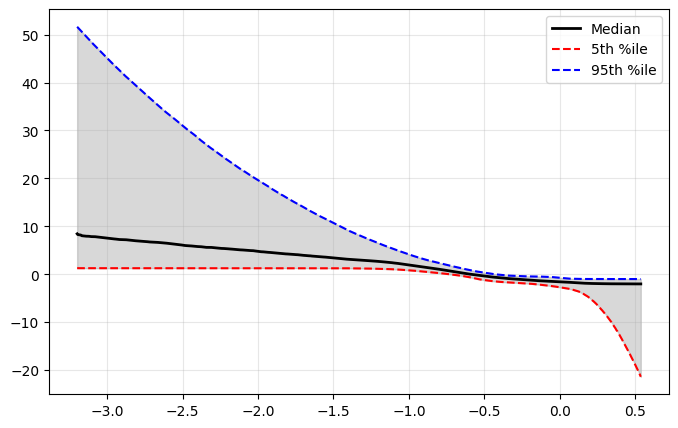

In [39]:
# def plot_bootstrap_percentiles(data, x, ax=None):
#     if ax is None:
#         fig, ax = plt.subplots(figsize=(8, 5))
#     else:
#         fig = ax.get_figure()
    
#     x = np.array(x)
#     p = np.nanpercentile(data, [5, 50, 95], axis=0)
#     print(p[0][0])
    
#     ax.plot(x, p[1], 'k-', label='Median', linewidth=2)
#     ax.plot(x, p[0], 'r--', label='5th %ile')
#     ax.plot(x, p[2], 'b--', label='95th %ile')
#     ax.fill_between(x, p[0], p[2], color='gray', alpha=0.3)
#     ax.legend()
#     ax.grid(alpha=0.3)
    
#     return fig, ax
    
# plot_bootstrap_percentiles(np.array(old_data['log_lrPlus']), old_data['scores'])